In [9]:
import sys
import spotipy
import spotipy.util as util

from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

SPOTIPY_REDIRECT_URI='http://localhost:8888/callback'
SPOTIPY_CLIENT_SECRET='c02f97ddd119470d8e24b290722c7490'
SPOTIPY_CLIENT_ID='647ffb8c163b4882be0cafe4bf1352d5'
SCOPE='user-library-read'
USERNAME = '29n1g5zgbzcs413wmovhqdguz'

HIPHOP_PLAYLIST = '7lNigxwnh2dbFuKBtgXlys'
HIPHOP_PLAYLIST_USER = '1279497600'

COUNTRY_PLAYLIST = '4Fzi6FwTsiWkx6wrWkdwTR'
COUNTRY_PLAYLIST_USER = '12131895985'

In [2]:
# !rm .cache-29n1g5zgbzcs413wmovhqdguz

In [3]:
token = util.prompt_for_user_token(username=USERNAME,
                           scope=SCOPE,
                           client_id=SPOTIPY_CLIENT_ID,
                           client_secret=SPOTIPY_CLIENT_SECRET,
                           redirect_uri=SPOTIPY_REDIRECT_URI)

if not token:
    print("Can't get token for username", username)
    sys.exit(1)

sp = spotipy.Spotify(auth=token)

In [10]:
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

def get_audio_features(ids):
    audio_feats = []
    
    for i in range(0, len(ids), 100):
        audio_feats += sp.audio_features(ids[i:i+100])
        
    return audio_feats

def extract_feature(features, feature):
    return [track[feature] for track in features]

def get_data(users, playlists):
    track_list = [get_playlist_tracks(user, playlist) for user, playlist in zip(users, playlists)]
    trackidlist = [[track['track']['id'] for track in tracks] for tracks in track_list]
    return [get_audio_features(trackids) for trackids in trackidlist]
    
def plot_feature_importances(data):
    datamatrix = np.zeros(13)
    lengths = []

    for audiofeatures in data:
        part = np.delete(np.array([np.array(list(feature.values())) for feature in audiofeatures if feature != None]), [0, 2, 9, 11, 15], 1)
        lengths += [len(part)]
        datamatrix = np.vstack((datamatrix, np.delete(np.array([np.array(list(feature.values())) for feature in audiofeatures if feature != None]), [0, 2, 9, 11, 15], 1)))
    
    datamatrix = np.delete(datamatrix, 0, 0)
    indices = np.delete(list(data[0][1].keys()), [0, 2, 9, 11, 15], 0)

    y = []
    for i in range(len(lengths)):
        y += [i] * lengths[i]

    clf = RandomForestClassifier()
    clf.fit(datamatrix, y)

    importance = pd.DataFrame(clf.feature_importances_, index=indices, columns=["importance"])

    importance["Std"] = np.std([tree.feature_importances_ for tree in clf.estimators_], axis = 0)

    x = np.arange(importance.shape[0])
    y = importance.iloc[:, 0]
    yerr = importance.iloc[:, 1]

    plt.figure(figsize=(10, 7))
    plt.bar(x, y, yerr=yerr, align="center")

    plt.show()
    
    
def plot_feature_importances_from_pickle(data, indices, n):
    lengths = []

    datamatrix = np.zeros(13)
    
    for genre in data:
        lengths += [len(genre)]
        datamatrix = np.vstack((datamatrix, genre))
        
    datamatrix = np.delete(datamatrix, 0, 0)
    
    y = []
    for i in range(len(lengths)):
        y += [i] * lengths[i]
        
    all_importances = []
    
    for _ in range(n):
        clf = RandomForestClassifier()
        clf.fit(datamatrix, y)
        all_importances += [tree.feature_importances_ for tree in clf.estimators_]

    importance = pd.DataFrame(np.mean(all_importances, 0), index=indices, columns=["importance"])
    importance['std'] = np.std(all_importances, 0)
        
    x = np.arange(importance.shape[0])
    y = importance.iloc[:, 0]
    yerr = importance.iloc[:, 1]

    plt.figure(figsize=(10, 7))
    plt.bar(x, y, yerr=yerr, align="center")
    plt.xticks(x, indices, rotation = 90, ha='right')

    plt.show()

In [14]:
data = get_data([HIPHOP_PLAYLIST_USER, COUNTRY_PLAYLIST_USER], [HIPHOP_PLAYLIST, COUNTRY_PLAYLIST])

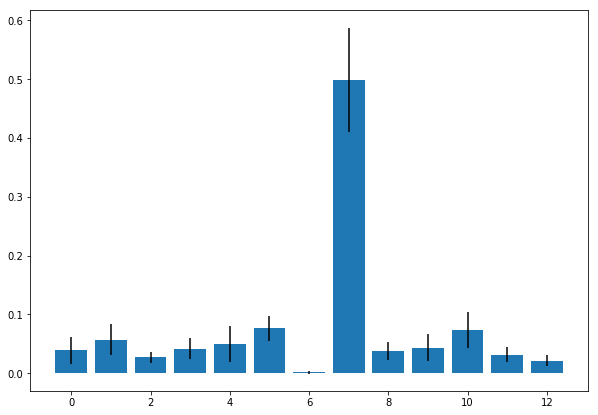

In [196]:
plot_feature_importances(data)

In [5]:
import pickle

In [11]:
funk_features = pd.read_pickle(open("datasets/funk_features", "rb"))
punk_features = pd.read_pickle(open("datasets/punk_features", "rb"))
rock_features = pd.read_pickle(open("datasets/rock_features", "rb"))
jazz_features = pd.read_pickle(open("datasets/jazz_features", "rb"))

vaporwave_features = pd.read_pickle(open("datasets/vaporwave_features", "rb"))
classical_features = pd.read_pickle(open("datasets/classical_features", "rb"))
hiphop_features    = pd.read_pickle(open("datasets/hiphop_features",    "rb"))
house_features     = pd.read_pickle(open("datasets/house_features",     "rb"))

meditation_features = pd.read_pickle("datasets/meditation_features")
hardcore_features   = pd.read_pickle("datasets/hardcore_features")
kpop_features       = pd.read_pickle("datasets/k-pop_features")
metal_features      = pd.read_pickle("datasets/metal_features")

rap_features    = pd.read_pickle("datasets/rap_features")
soul_features   = pd.read_pickle("datasets/soul_features")
techno_features = pd.read_pickle("datasets/techno_features")
grunge_features = pd.read_pickle("datasets/grunge_features")

In [12]:
# test if column indices are the same for all 
indices = list(funk_features.columns)
featureslist = [funk_features, punk_features, rock_features, jazz_features, vaporwave_features, classical_features, hiphop_features, house_features, meditation_features, hardcore_features, kpop_features, metal_features]
for f in featureslist:
    if not list(f.columns) == indices:
        print("TEST FAILED")
        break
else:
    print("TEST SUCCEEDED")

TEST SUCCEEDED


In [13]:
indices = list(funk_features.columns)

funk = funk_features.as_matrix()
punk = punk_features.as_matrix()
rock = rock_features.as_matrix()
jazz = jazz_features.as_matrix()

vaporwave = vaporwave_features.as_matrix()
classical = classical_features.as_matrix()
hiphop    = hiphop_features.as_matrix()
house     = house_features.as_matrix()

meditation = meditation_features.as_matrix()
hardcore   = hardcore_features.as_matrix()
metal      = metal_features.as_matrix()
kpop       = kpop_features.as_matrix()

rap    = rap_features.as_matrix()
soul   = soul_features.as_matrix()
techno = techno_features.as_matrix()
grunge = grunge_features.as_matrix()

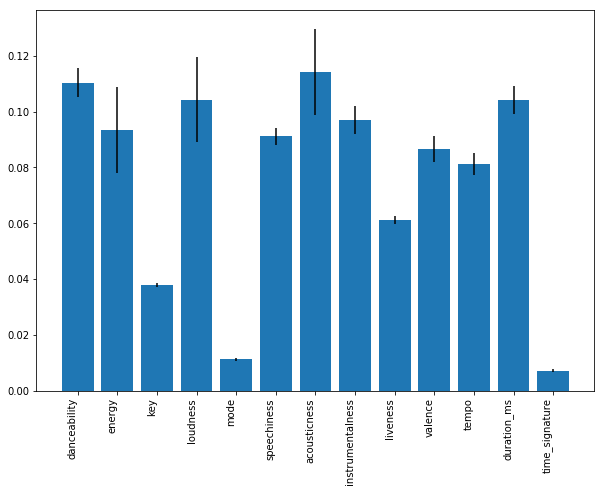

In [14]:
plot_feature_importances_from_pickle([punk, funk, rock, jazz, vaporwave, classical, hiphop, house, kpop, hardcore, meditation, metal, rap, soul, techno, grunge], indices, 10)

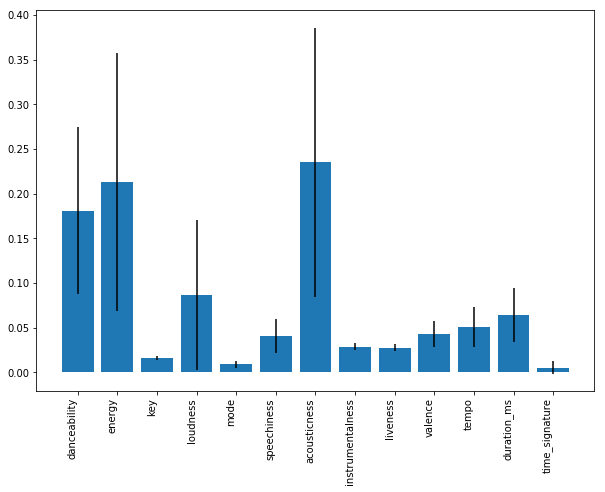

In [11]:
plot_feature_importances_from_pickle([punk, funk], indices, 10)